# Linear fit for the ON/OFF speech patterns (phrasal groupings)

In [1]:
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import statsmodels.api as sm
from utils import load_fragment_times, zscore, shuffle_fragments

%matplotlib inline

In [2]:
hdir = '..'
speech = load_fragment_times(hdir, 'speech')
nonspeech = load_fragment_times(hdir,'nonspeech')
a = np.load('../data/audio_envelope_100Hz.npy')
onoff = np.load('../data/speech_on_off_100Hz.npy')

In [4]:
subj = 's1'
x    = np.load('../data/' + subj + '_HD_100Hz_hfb.npy')
pm = np.load('../results/ttest_ecog_speech_nonspeech_'+subj+'_pmask.npz')['pmask_bonf'] # pmask from the first ttest
grid = np.load('../data/' + subj + '_HD_grid.npy')
n = x.shape[-1]

In [5]:
# shift to max cor lag per fragment
D = np.load('../results/xcor_' + subj + '_audio_envelope_100Hz_hfb_spearman.npz')
start = 390
r_spe = D['r_spe'][:,:,start:-349]
rm = np.argmax(r_spe, 2)

maxr = np.zeros(rm.shape)
for i, f in enumerate(rm):
    for ir, r in enumerate(f):
        maxr[i, ir] = r_spe[i, ir][rm[i, ir]]

offset = 400 - start
rm = rm - offset

In [6]:
# select fragments and concatenate over time
x_spe, o_spe = [], []
for ifrag, spe_frag in enumerate(speech):
    x_spe.append([])
    o_spe.append(onoff[range(spe_frag[0], spe_frag[1])])
    for i in range(n):
        x_spe[-1].append(x[range(spe_frag[0]+rm[ifrag, i], spe_frag[1]+rm[ifrag, i]), i])
x_spe = np.array(x_spe)
o_spe = np.array(o_spe)

x_spe_c = x_spe.swapaxes(1, 2).reshape((-1, n))
o_spe_c = o_spe.reshape(-1, )

In [7]:
# find ols
x_spe_cz = zscore(x_spe_c)
o_basis = np.vstack([np.ones(o_spe_c.shape[0]), o_spe_c]).T

x_betas, x_sumres, _, _ = linalg.lstsq(o_basis, x_spe_cz)

x_fit = o_basis.dot(x_betas)
x_rsd = x_spe_cz - x_fit

In [10]:
# beta weights
bs_masked = zscore(x_betas[1]).copy()
#bs_masked = x_betas[1].copy()
bs_masked[np.setdiff1d(range(n), pm)] = 0

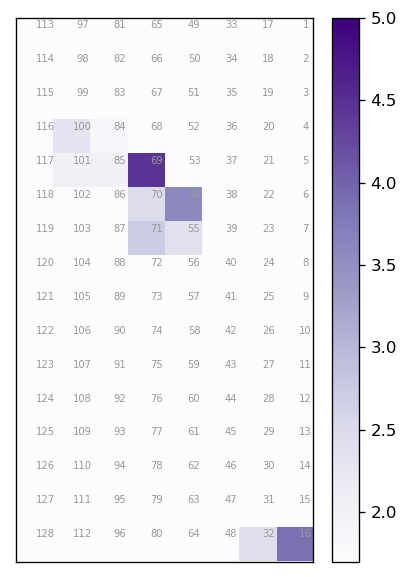

In [12]:
# display beta weights for s1
plt.figure(figsize=(4, 6), dpi=120)
cmap = plt.get_cmap('Purples')
cmap.set_bad((.7, .7, .7))
plt.imshow(bs_masked[grid], aspect='auto', cmap = cmap, vmin = 1.7, vmax = 5, extent=[0, grid.shape[-1], 0, grid.shape[0]]) # for zscored
# plt.imshow(bs_masked[grid], aspect='auto', cmap = cmap, vmin = 0, vmax = 1, extent=[0, grid.shape[-1], 0, grid.shape[0]]) # for non-ascored
for (i, j), k in np.ndenumerate(np.flipud(grid)):
    plt.gca().text(j+.8, i+.8, k+1, ha='center', va='center', color=(.6, .6, .6), fontsize=6)
plt.xticks([])
plt.yticks([])
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.colorbar()
plt.show()

In [13]:
# shift testing for ols
sm_f, sm_fp, sm_ts, sm_tps, sm_w = [], [], [], [], []
for i in range(n):
    est = sm.OLS(x_spe_cz[:, i], o_basis)
    est2 = est.fit()
    sm_f.append(est2.fvalue)
    sm_fp.append(est2.f_pvalue)
    sm_ts.append(est2.tvalues)
    sm_tps.append(est2.pvalues)
    sm_w.append(est2.params)
sm_f, sm_fp, sm_ts, sm_tps, sm_w  = np.array(sm_f), np.array(sm_fp), np.array(sm_ts), np.array(sm_tps), np.array(sm_w)

In [14]:
# permutation baseline
nperms = 10000
sm_fs_perm, sm_ts_perm, sm_tps_perm, sm_w_perm = [], [], [], []
for i in range(n):
    sm_fs_perm.append([])
    sm_ts_perm.append([])
    sm_tps_perm.append([])
    sm_w_perm.append([])
    for perm in range(nperms):
        est = sm.OLS(shuffle_fragments(x_spe_cz[:, i]), o_basis)
        est2 = est.fit()
        sm_fs_perm[-1].append(est2.fvalue)
        sm_ts_perm[-1].append(est2.tvalues)
        sm_tps_perm[-1].append(est2.pvalues)
        sm_w_perm[-1].append(est2.params)

In [18]:
sm_fs_perm, sm_ts_perm, sm_tps_perm, sm_w_perm  = 
                        np.array(sm_fs_perm), np.array(sm_ts_perm), np.array(sm_tps_perm), np.array(sm_w_perm)
prcnl = np.percentile(sm_ts_perm[:, :, -1], 100-.001/n, axis=1)
print(prcnl[pm])
print(sm_ts[pm, -1])

[12.90489187 18.63364483 16.85158673 12.35519961 15.69094525 14.45156456
 12.58527429 17.77762097 15.09360347 12.54883678 15.51023149 14.90000498
 15.69139602 13.66611464 13.36501741 16.2299297  13.9508679  11.82662647
 14.12508274 13.48412409]
[18.98383994 44.44705316 34.23963207 14.29324049 42.45856993 33.85822833
 11.78651213 48.68840498 34.41951311 36.21243987 15.66838528 30.31707569
 31.40395156 24.30915013 17.9246712  33.36466115 31.37421343 14.21694502
  9.73428345 17.06396176]


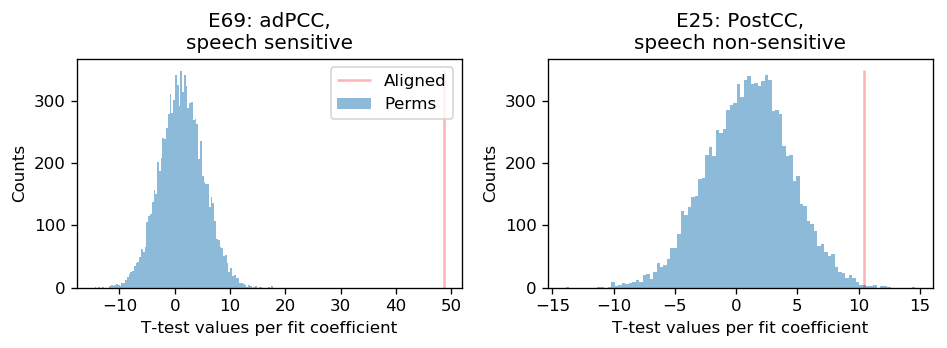

In [52]:
plt.figure(figsize=(8, 3), dpi=120)
plt.subplot(121)
plt.hist(sm_ts_perm[68,:,-1], 100, alpha=.5)
plt.vlines(x=sm_ts[68, -1], ymin=0, ymax=350, color='red', alpha=.3)
plt.ylabel('Counts')
plt.xlabel('T-test values per fit coefficient')
plt.title('E69: adPCC,\nspeech sensitive')
plt.legend(['Aligned', 'Perms'])

plt.subplot(122)
plt.hist(sm_ts_perm[24,:,-1], 100, alpha=.5)
plt.vlines(x=sm_ts[27, -1], ymin=0, ymax=350, color='red', alpha=.3)
plt.ylabel('Counts')
plt.xlabel('T-test values per fit coefficient')
plt.title('E25: PostCC,\nspeech non-sensitive')
plt.tight_layout()
plt.show()